In [1]:
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [2]:
df0 = pd.read_csv("../testResults/test7.csv")
df0['time'] = pd.to_numeric(df0['time'])
df0['part.time'] = pd.to_numeric(df0['part.time'])
df0

,cfg,thread no.,time,part.time
0,./assets/spider0.sumocfg,1,508.012,2335.690
1,./assets/spider0.sumocfg,1,526.499,780.297
2,./assets/spider0.sumocfg,1,523.159,780.540
3,./assets/spider0.sumocfg,2,1418.830,2498.500
4,./assets/spider0.sumocfg,2,1443.340,779.342
...,...,...,...,...
70,./assets/bologna-sim/osm.sumocfg,6,8748.090,789.328
71,./assets/bologna-sim/osm.sumocfg,6,8611.540,826.805
72,./assets/bologna-sim/osm.sumocfg,12,8989.570,6156.050
73,./assets/bologna-sim/osm.sumocfg,12,8858.390,839.464


In [3]:
df1 = df0.groupby(["cfg", "thread no."]).agg({
    'time': 'mean',
    'part.time': 'max'
}).reset_index()
df1["time"] = df1["time"].apply(lambda x: round(x / 1000, 2))
df1["cfg"] = df1["cfg"].apply(lambda x: x.replace("./assets/", ""))

df1

,cfg,thread no.,time,part.time
0,bologna-sim/osm.sumocfg,1,8.54,13093.000
1,bologna-sim/osm.sumocfg,2,11.03,11236.000
2,bologna-sim/osm.sumocfg,4,10.92,9469.240
3,bologna-sim/osm.sumocfg,6,8.55,7296.070
4,bologna-sim/osm.sumocfg,12,8.83,6156.050
5,grid_large.sumocfg,1,74.96,94696.600
6,grid_large.sumocfg,2,35.77,104101.000
7,grid_large.sumocfg,4,19.90,101596.000
8,grid_large.sumocfg,6,16.73,97179.800
9,grid_large.sumocfg,12,11.78,93592.300


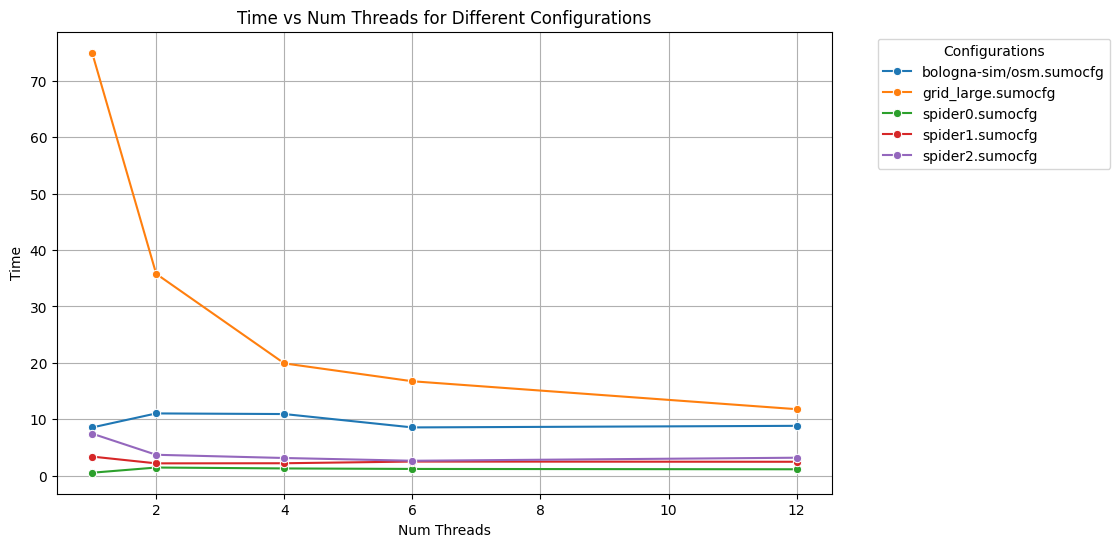

In [4]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df1, x='thread no.', y='time', hue='cfg', marker='o')
plt.title('Time vs Num Threads for Different Configurations')
plt.xlabel('Num Threads')
plt.ylabel('Time')
plt.legend(title='Configurations', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

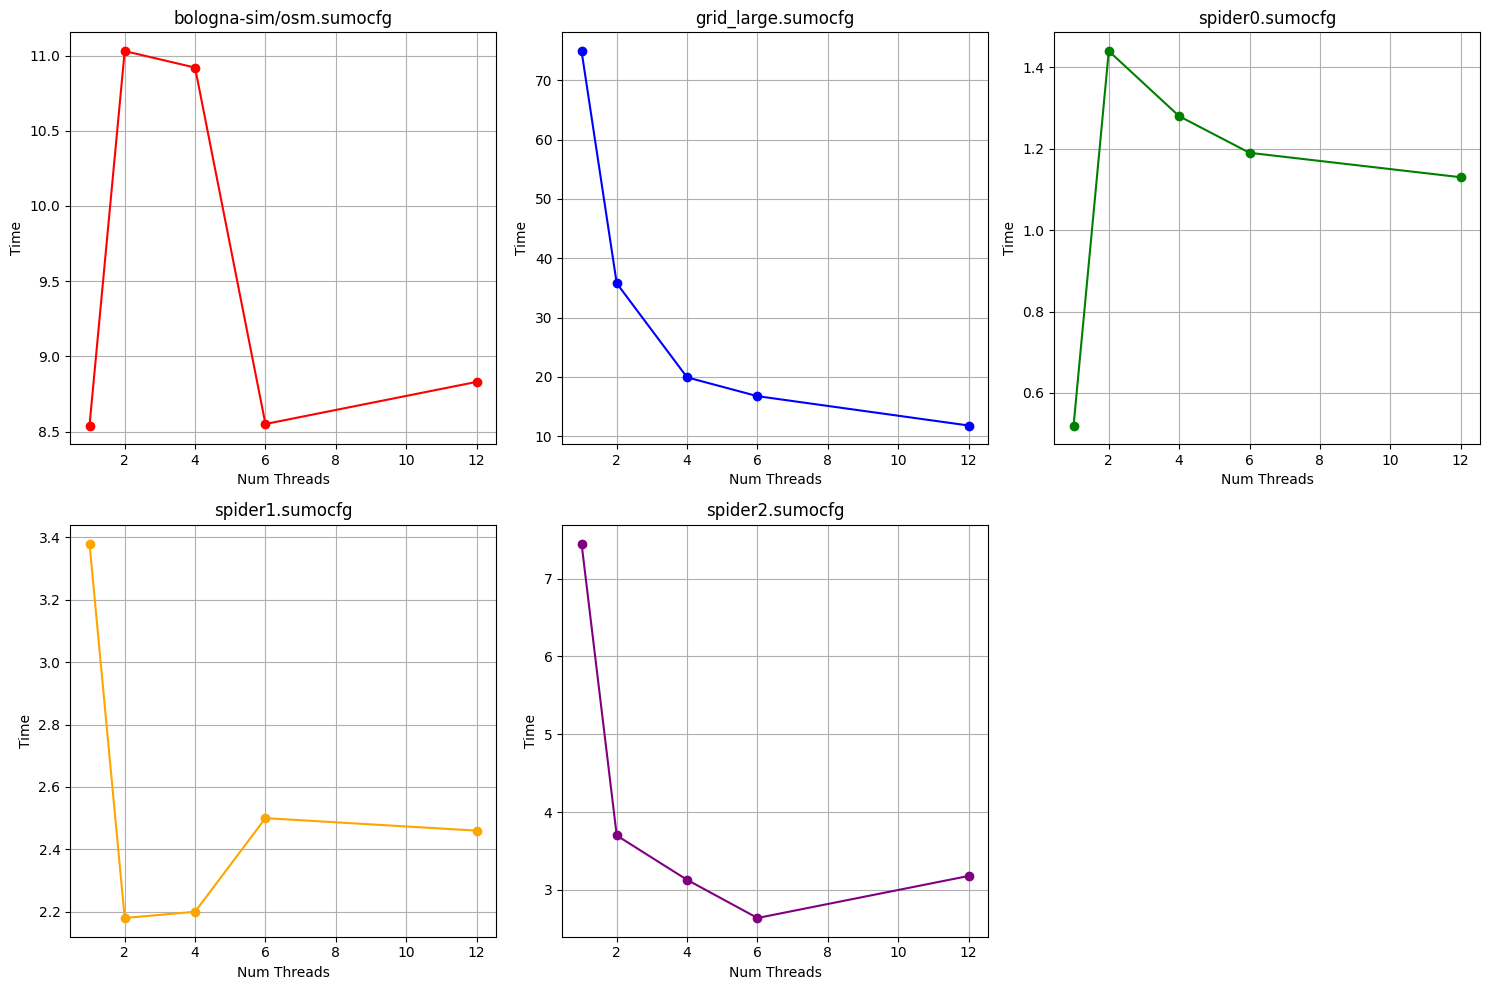

In [8]:
unique_configs = df1['cfg'].unique()
num_configs = len(unique_configs)
num_cols = 3  # Number of columns in the grid, you can adjust this

num_rows = int(np.ceil(num_configs / num_cols))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

colors = itertools.cycle(['red', 'blue', 'green', 'orange', 'purple', 'magenta', 'cyan', 'yellow'])

for i, (config, color) in enumerate(zip(unique_configs, colors)):
    row = i // num_cols
    col = i % num_cols
    data = df1[df1['cfg'] == config]
    ax = axes[row, col] if num_rows > 1 else axes[col]
    ax.plot(data['thread no.'], data['time'], marker='o', color=color)
    ax.set_title(f'{config}')
    ax.set_xlabel('Num Threads')
    ax.set_ylabel('Time')
    ax.grid(True)

# Hide any empty subplots
for i in range(len(unique_configs), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    if num_rows > 1:
        axes[row, col].axis('off')
    else:
        axes[col].axis('off')

plt.tight_layout()
plt.show()

In [6]:
import os, sys
if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(os.path.join(tools))
    from sumolib.net import readNet
    from sumolib.net.edge import Edge
    from sumolib.net.node import Node
    import sumolib
else:
    print("please declare environment variable 'SUMO_HOME'")

import lxml.etree
from lxml.etree import _Element as Element, _ElementTree as ElementTree

In [7]:
cfg_props = []

for cfg in unique_configs:
    file = os.path.join("../assets", cfg)
    
    cfg_tree: ElementTree = lxml.etree.parse(file)
    cfg_root: Element = cfg_tree.getroot()
    cfg_dir = os.path.dirname(file)
    
    net_file: str = os.path.join(cfg_dir, cfg_root.find("./input/net-file").attrib["value"])
    route_files: list[str] = [os.path.join(cfg_dir, x) for x in cfg_root.find("./input/route-files").attrib["value"].split(",")]
    
    net: sumolib.net.Net = readNet(net_file)
    nodes: list[Node] = net.getNodes()
    edges: list[Edge] = net.getEdges()
    
    num_vehicles = 0
    for routef in route_files:
        route_tree: ElementTree = lxml.etree.parse(routef)
        route_root: Element = route_tree.getroot()
        num_vehicles += len(route_root.findall("vehicle"))
        num_vehicles += len(route_root.findall("trip"))
    
    cfg_props.append({'cfg': cfg, 'nodes': len(nodes), 'edges': len(edges), 'vehicles': num_vehicles})
    
df0 = DataFrame(cfg_props).set_index("cfg")
df0

,nodes,edges,vehicles
cfg,,,
bologna-sim/osm.sumocfg,473,852,2757
grid_large.sumocfg,10000,39600,1000
spider0.sumocfg,21,70,1000
spider1.sumocfg,280,1106,1000
spider2.sumocfg,700,2786,1000


In [21]:
df0.style.to_latex(
    "../../elaborato/chap4_cfg_table.tex",
    hrules=True,
    clines="all;data",
)